In [567]:
import numpy as np
import random
import scipy.stats as ss
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [568]:
def extract_data(graph, opinion0_prob):
    G = nx.number_of_nodes(graph)
    nodes = list(graph.nodes())
    opinion0_count = int(opinion0_prob*G)
    opinions = [0]*opinion0_count + [1]*(G - opinion0_count)
    random.shuffle(opinions)
    neighbors = [0]*G
    for i in range(G):
        neighbors[i] = list(graph.neighbors(nodes[i]))
    return opinions, neighbors

In [569]:
def sym_to_consensus(graph, opinion0_prob, q, q0, epsilon, big_steps, max_steps = 10**6):
    last_values = np.empty(10000)
    data = extract_data(graph, opinion0_prob)
    if type(epsilon) == float:
        epsilon = [epsilon]*nx.number_of_nodes(graph)
    opinions, neighbors = data
    len_opinions = len(opinions)
    step = 0
    while len(list(set(opinions))) == 2 and step < max_steps:
        chosen = np.random.randint(0, len_opinions)
        opinion = opinions[chosen]
        chosen_neighbors = random.choices(neighbors[chosen], k = q)
        chosen_opinions = [opinions[i] for i in chosen_neighbors]
        epsilon_chosen = epsilon[chosen]
        if opinion == 0 and (sum(chosen_opinions) >= q0 or \
                                      (epsilon_chosen  > np.random.uniform() and sum(chosen_opinions) > 0)):
            opinions[chosen] = 1
        elif opinion == 1 and (sum(chosen_opinions) < q0 or \
                                      (epsilon_chosen  > np.random.uniform() and sum(chosen_opinions) > 0)):
            opinions[chosen] = 0
        step += 1
        if step >= max_steps - 10000:
            print(step)
            last_values[10000 - max_steps + step - 1] = sum(opinions)
    if step > max_steps - 10001:
        last_values.append((epsilon_chosen, len_opinions))
        big_steps.append(last_values)
    return step

In [570]:
def monte_carlo_sym_random(n, graph_prob, MC_steps, graph, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    for i in range(MC_steps):
        g = nx.erdos_renyi_graph(n, graph_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            g = nx.erdos_renyi_graph(ns[n], graph_prob)
        mean_step += sym_to_consensus(g, opinion0_prob, q, q0, epsilon, big_steps_random, max_steps)
    return mean_step/MC_steps

In [571]:
def monte_carlo_sym_barabasi(n, barabasi_edges, MC_steps, graph, opinion0_prob, q, q0, epsilon, max_steps):
    if barabasi_edges < q:
        raise ValueError('q > barabasi_edges')
    mean_step = 0
    for i in range(MC_steps):
        g = nx.barabasi_albert_graph(n, barabasi_edges)
        mean_step += sym_to_consensus(g, opinion0_prob, q, q0, epsilon, big_steps_barabasi, max_steps)
    return mean_step/MC_steps

In [572]:
def monte_carlo_sym_watts(n, watts_edges, watts_prob, MC_steps, graph, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    for i in range(MC_steps):
        g = nx.watts_strogatz_graph(ns[n], watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            g = nx.watts_strogatz_graph(ns[n], watts_edges, watts_prob)
        mean_step += sym_to_consensus(g, opinion0_prob, q, q0, epsilon, big_steps_watts, max_steps)
    return mean_step/MC_steps

In [573]:
def consensus_time_random(ns, graph_prob, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**6):
    mean_times = np.empty(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym_random(ns[n], graph_prob, MC_steps, g, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

In [574]:
def consensus_time_barabasi(ns, barabasi_edges, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**6):
    mean_times = np.empty(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym_barabasi(ns[n], barabasi_edges, MC_steps, g, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

In [575]:
def consensus_time_watts(ns, watts_edges, watts_prob, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**6):
    mean_times = np.empty(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym(ns, [n], watts_edges, watts_prob, MC_steps, g, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

In [576]:
big_steps_random = []
big_steps_watts = []
big_steps_barabasi = []
big_steps_random2 = []

### Barabasi

In [577]:
ns = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
epsilons = np.arange(0.1, 0.45, 0.05)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5
barabasi_edges = 8

In [579]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_barabasi(ns, barabasi_edges, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**6))

0.1
100
250
0.2
100
250
Wall time: 1.32 s


In [580]:
df = pd.DataFrame(l, columns = ns)
df.to_csv('Barabasi.csv')
df = pd.DataFrame(big_steps_barabasi, columns = ns)
df.to_csv('Barabasi_big.csv')

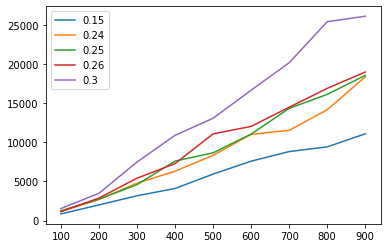

In [441]:
for e in l:
    plt.plot(ns, e)
plt.legend(epsilons)

### Watts

In [447]:
ns = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
epsilons = np.arange(0.1, 0.45, 0.05)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5 
watts_edges, watts_prob = 12, 0.5

In [464]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_watts(ns, watts_edges, watts_prob, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**6))

0.15
100
200
300
400
500
600
700
800
900
1000
0.24
100
200
300
400
500
600
700
800
900
1000
0.25
100
200
300
400
500
600
700
800
900
1000
0.26
100
200
300
400
500
600
700
800
900
1000
0.3
100
200
300
400
500
600
700
800
900
1000
Wall time: 3min 22s


In [ ]:
df = pd.DataFrame(l, columns = ns)
df.to_csv('Watts.csv')
df = pd.DataFrame(big_steps_watts, columns = ns)
df.to_csv('Watts_big.csv')

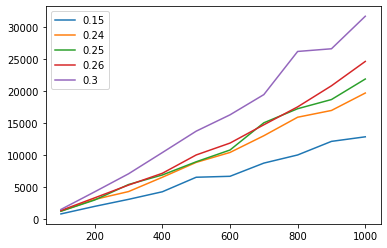

In [465]:
for e in l:
    plt.plot(ns, e)
plt.legend(epsilons)

### Random

In [482]:
ns = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
epsilons = np.arange(0.1, 0.45, 0.05)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5 
graph_prob = 1

In [472]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_random(ns, graph_prob, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**6))

0.15
100
200
300
400
500
600
700
800
900
1000
0.24
100
200
300
400
500
600
700
800
900
1000
0.25
100
200
300
400
500
600
700
800
900
1000
0.26
100
200
300
400
500
600
700
800
900
1000
0.3
100
200
300
400
500
600


NameError: name 'max_step' is not defined

In [ ]:
df = pd.DataFrame(l, columns = ns)
df.to_csv('Random.csv')
df = pd.DataFrame(big_steps_random, columns = ns)
df.to_csv('random_big.csv')

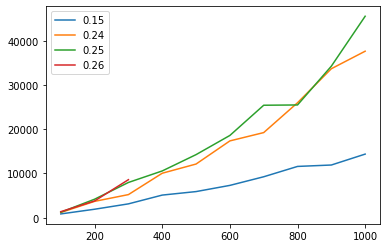

In [473]:
for e in l[:-1]:
    plt.plot(ns, e)
plt.plot(ns[:3], l[-1][:3])
plt.legend(epsilons)

In [ ]:
def monte_carlo_sym_random(n, graph_prob, MC_steps, graph, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    for i in range(MC_steps):
        g = nx.erdos_renyi_graph(n, graph_prob)
        while min(dict(g.degree()).values()) < q:
            print('Need more neighbors')
            g = nx.erdos_renyi_graph(ns[n], graph_prob)
        mean_step += sym_to_consensus(g, opinion0_prob, q, q0, epsilon, big_steps_random2, max_steps)
    return mean_step/MC_steps

In [ ]:
ns = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
epsilons = np.arange(0.1, 0.45, 0.05)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5 
graph_prob = 0.6

In [ ]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_random(ns, graph_prob, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**6))

In [ ]:
df = pd.DataFrame(l, columns = ns)
df.to_csv('Random2.csv')
df = pd.DataFrame(big_steps_random2, columns = ns)
df.to_csv('random_big2.csv')

In [ ]:
g = nx.erdos_renyi_graph(10000, 1)

In [411]:
data = extract_data(g, 0.5)
q = 2
q0 = 4
epsilon = [0]*nx.number_of_nodes(g)
step = 0

In [412]:
opinions, neighbors = data
len_opinions = len(opinions)
while len(list(set(opinions))) == 2:
    chosen = np.random.randint(0, len_opinions)
    opinion = opinions[chosen]
    epsilon_chosen = epsilon[chosen]
    chosen_neighbors = random.choices(neighbors[chosen], k = q)
    chosen_opinions = [opinions[i] for i in chosen_neighbors]
    if opinion == 0 and (sum(chosen_opinions) >= q0 or \
                                  (epsilon_chosen > np.random.uniform() and sum(chosen_opinions) > 0)):
        opinions[chosen] = 1
    elif opinion == 1 and (sum(chosen_opinions) < q0 or \
                                  (epsilon_chosen > np.random.uniform() and sum(chosen_opinions) > 0)):
        opinions[chosen] = 0
    step += 1
    if step % 100 == 0:
        print(step)
        print(sum(opinions))
        #print(opinions)

100
4947
200
4904
300
4856
400
4809
500
4760
600
4717
700
4668
800
4620
900
4577
1000
4529
1100
4489
1200
4456
1300
4415
1400
4374
1500
4332
1600
4288
1700
4236
1800
4201
1900
4155
2000
4112
2100
4071
2200
4033
2300
3990
2400
3947
2500
3909
2600
3862
2700
3826
2800
3797
2900
3756
3000
3717
3100
3690
3200
3656
3300
3620
3400
3576
3500
3537
3600
3505
3700
3466
3800
3435
3900
3402
4000
3373
4100
3335
4200
3309
4300
3280
4400
3243
4500
3219
4600
3188
4700
3158
4800
3113
4900
3083
5000
3052
5100
3021
5200
2991
5300
2965
5400
2939
5500
2901
5600
2869
5700
2839
5800
2810
5900
2778
6000
2751
6100
2725
6200
2704
6300
2675
6400
2655
6500
2634
6600
2609
6700
2585
6800
2558
6900
2539
7000
2519
7100
2496
7200
2467
7300
2438
7400
2418
7500
2389
7600
2361
7700
2339
7800
2319
7900
2294
8000
2279
8100
2256
8200
2233
8300
2208
8400
2191
8500
2168
8600
2150
8700
2125
8800
2107
8900
2079
9000
2053
9100
2031
9200
2016
9300
2006
9400
1985
9500
1963
9600
1938
9700
1907
9800
1893
9900
1879
10000
1863
10100
18

88100
3
88200
3
88300
3
88400
3
88500
3
88600
3
88700
3
88800
3
88900
3
89000
3
89100
3
89200
3
89300
3
89400
3
89500
3
89600
3
89700
3
89800
3
89900
3
90000
3
90100
3
90200
3
90300
3
90400
3
90500
3
90600
3
90700
3
90800
3
90900
3
91000
3
91100
3
91200
3
91300
3
91400
3
91500
3
91600
3
91700
3
91800
3
91900
3
92000
3
92100
3
92200
3
92300
3
92400
3
92500
3
92600
3
92700
3
92800
3
92900
3
93000
3
93100
3
93200
3
93300
3
93400
3
93500
3
93600
3
93700
3
93800
3
93900
3
94000
3
94100
2
94200
2
94300
2
94400
2
94500
2
94600
2
94700
2
94800
2
94900
2
95000
2
95100
2
95200
2
95300
2
95400
2
95500
1
95600
1
95700
1
95800
1
95900
1
96000
1
96100
1
96200
1
96300
1
96400
1
96500
1
96600
1
96700
1
96800
1
96900
1
97000
1
97100
1
97200
1
97300
1
97400
1
97500
1
97600
1
97700
1
97800
1
97900
1
98000
1
98100
1
98200
1
98300
1
98400
1
98500
1
98600
1
98700
1
98800
1
98900
1
99000
1
99100
1
99200
1
99300
1
99400
1
99500
1
99600
1
99700
1
99800
1
99900
1
100000
1
100100
1
100200
1
100300
1
100400
1
100

In [84]:
d = {i:np.random.randint(0, 2) for i in range(100)}

In [85]:
q = 6
q0 = 5
epsilon = 0.2
step = 0
opinions = []

In [124]:
opinions = []

In [125]:
while list(set(d.values())) != [0] and list(set(d.values())) != [1]:
    chosen = random.choices(list(d.keys()), k = q + 1)
    if d[chosen[0]] == 0 and sum([d[key] for key in chosen[1:]]) >= q0:
        d[chosen[0]] = 1
    elif d[chosen[0]] == 1 and sum([d[key] for key in chosen[1:]]) < q0:
        d[chosen[0]] = 0
    elif np.random.uniform() <= epsilon and d[chosen[0]] == 0:
        d[chosen[0]] = 1
    elif np.random.uniform() <= epsilon and d[chosen[0]] == 1:
        d[chosen[0]] = 0
    step += 1
    if step % 10000 == 0:
        print(step)
        print(list(d.values()).count(0))
    if step > 26*10**6 and step % 1000 == 0:
        opinions.append(list(d.values()).count(0))

31420000
84
31430000
80
31440000
86
31450000
84
31460000
87
31470000
88
31480000
84
31490000
84
31500000
79
31510000
83
31520000
81
31530000
82
31540000
75
31550000
84
31560000
87
31570000
87
31580000
85
31590000
88
31600000
84
31610000
81
31620000
86
31630000
82
31640000
87
31650000
76
31660000
86
31670000
81
31680000
86
31690000
87
31700000
81
31710000
86
31720000
89
31730000
81
31740000
81
31750000
87
31760000
81
31770000
85
31780000
81
31790000
88
31800000
86
31810000
78
31820000
87
31830000
83
31840000
86
31850000
87
31860000
87
31870000
82
31880000
81
31890000
87
31900000
86
31910000
87
31920000
88
31930000
84
31940000
85
31950000
81
31960000
87
31970000
77
31980000
82
31990000
79
32000000
84
32010000
81
32020000
92
32030000
84
32040000
86
32050000
85
32060000
84
32070000
82
32080000
91
32090000
89
32100000
87
32110000
87
32120000
82
32130000
83
32140000
81
32150000
78
32160000
82
32170000
84
32180000
81
32190000
82
32200000
79
32210000
80
32220000
80
32230000
85
32240000
87
3225

KeyboardInterrupt: 